----

-----

# ¿Cuál es la mejor tarifa?

Trabajare como analista para el operador de telecomunicaciones Megaline. La empresa ofrece a sus clientes dos tarifas de prepago, Surf y Ultimate. El departamento comercial quiere saber cuál de las tarifas genera más ingresos para poder ajustar el presupuesto de publicidad.

Voy a realizar un análisis preliminar de las tarifas basado en una selección de clientes relativamente pequeña. Tendrás los datos de 500 clientes de Megaline: quiénes son los clientes, de dónde son, qué tarifa usan, así como la cantidad de llamadas que hicieron y los mensajes de texto que enviaron en 2018. El trabajo consiste en analizar el comportamiento de los clientes y determinar qué tarifa de prepago genera más ingresos.

## Inicialización

In [168]:
# Cargar todas las librerías
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import ttest_ind 
from scipy.stats import levene 

## Cargar datos

In [169]:
calls = pd.read_csv('/datasets/megaline_calls.csv')
internet = pd.read_csv('/datasets/megaline_internet.csv')
messages = pd.read_csv('/datasets/megaline_messages.csv')
plans = pd.read_csv('/datasets/megaline_plans.csv')
users = pd.read_csv('/datasets/megaline_users.csv')

## Preparar los datos

[Los datos para este proyecto se dividen en varias tablas. Explora cada una para tener una comprensión inicial de los datos. Si es necesario, haz las correcciones requeridas en cada tabla.]

## Tarifas

In [170]:
# Imprime la información general/resumida sobre el DataFrame de las tarifas

plans.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   messages_included      2 non-null      int64  
 1   mb_per_month_included  2 non-null      int64  
 2   minutes_included       2 non-null      int64  
 3   usd_monthly_pay        2 non-null      int64  
 4   usd_per_gb             2 non-null      int64  
 5   usd_per_message        2 non-null      float64
 6   usd_per_minute         2 non-null      float64
 7   plan_name              2 non-null      object 
dtypes: float64(2), int64(5), object(1)
memory usage: 256.0+ bytes


In [171]:
# Imprime una muestra de los datos para las tarifas
plans.head()

,messages_included,mb_per_month_included,minutes_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name
0,50,15360,500,20,10,0.03,0.03,surf
1,1000,30720,3000,70,7,0.01,0.01,ultimate


 ¿Hay algún problema (tipos de datos no adecuados, datos ausentes, etc.) que pudieran necesitar investigación y cambios adicionales? ¿Cómo se puede arreglar?]

Puedo observar datos ausentes que se van a tener que rellenar, que los consumidores gastan en promedio 45 usd mensual con un minimo de 20 usd y maximo 70 usd.
Voy a modificar la columa de mb por minuto por una que me diga los gb por minuto asi mismo con los minutos incluidos por horaas incluidas en el paquete, para homogenizar la informacion.

## Corregir datos

[Corregir los problemas obvios con los datos basándote en las observaciones iniciales.]

In [172]:
# Verificar cantidad de nulos por columna
print(plans.isnull().sum())

# Verificar filas con nulos
print(plans[plans.isnull().any(axis=1)])

messages_included        0
mb_per_month_included    0
minutes_included         0
usd_monthly_pay          0
usd_per_gb               0
usd_per_message          0
usd_per_minute           0
plan_name                0
dtype: int64
Empty DataFrame
Columns: [messages_included, mb_per_month_included, minutes_included, usd_monthly_pay, usd_per_gb, usd_per_message, usd_per_minute, plan_name]
Index: []


In [173]:
plans.drop_duplicates(inplace=True)

## Enriquecer los datos

[Agregar factores adicionales a los datos si crees que pudieran ser útiles.]

In [174]:
plans['gb_per_month_included'] = plans['mb_per_month_included'] / 1024 
plans['hours_included'] = plans['minutes_included'] / 60
plans.drop(columns= ['mb_per_month_included', 'minutes_included'], inplace=True)


## Usuarios/as

In [175]:
# Imprime la información general/resumida sobre el DataFrame de usuarios

users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   first_name  500 non-null    object
 2   last_name   500 non-null    object
 3   age         500 non-null    int64 
 4   city        500 non-null    object
 5   reg_date    500 non-null    object
 6   plan        500 non-null    object
 7   churn_date  34 non-null     object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [176]:
# Imprime una muestra de datos para usuarios
users.head(6)


,user_id,first_name,last_name,age,city,reg_date,plan,churn_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN
5,1005,Livia,Shields,31,"Dallas-Fort Worth-Arlington, TX MSA",2018-11-29,surf,NaN


No es necesario rellenar la colunma de churn_date porquqe la ausencia de este valor me indica que todos los usiarios de mi conjunto de datos siguen pagando el servicio de telefonia.
Voy a enriquecer la informacion utilizando un formato apropiado de fecha para la colunma reg_date, para extraer unicamente el mes en esta columna.

### Corregir los datos

[Corrige los problemas obvios con los datos basándote en las observaciones iniciales.]

In [177]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')

In [178]:
users['month_reg_date'] = users['reg_date'].dt.month

In [179]:
print(users)

     user_id first_name   last_name  age  \
0       1000   Anamaria       Bauer   45   
1       1001     Mickey   Wilkerson   28   
2       1002     Carlee     Hoffman   36   
3       1003   Reynaldo     Jenkins   52   
4       1004    Leonila    Thompson   40   
..       ...        ...         ...  ...   
495     1495      Fidel      Sharpe   67   
496     1496      Ariel    Shepherd   49   
497     1497      Donte     Barrera   49   
498     1498       Scot  Williamson   51   
499     1499      Shena     Dickson   37   

                                          city   reg_date      plan  \
0        Atlanta-Sandy Springs-Roswell, GA MSA 2018-12-24  ultimate   
1              Seattle-Tacoma-Bellevue, WA MSA 2018-08-13      surf   
2         Las Vegas-Henderson-Paradise, NV MSA 2018-10-21      surf   
3                                Tulsa, OK MSA 2018-01-28      surf   
4              Seattle-Tacoma-Bellevue, WA MSA 2018-05-23      surf   
..                                         ..

### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [180]:

users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month_reg_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,10
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,1
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,5


## Llamadas

In [181]:
# Imprime la información general/resumida sobre el DataFrame de las llamadas
calls.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 137735 entries, 0 to 137734
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         137735 non-null  object 
 1   user_id    137735 non-null  int64  
 2   call_date  137735 non-null  object 
 3   duration   137735 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.2+ MB


In [182]:
# Imprime una muestra de datos para las llamadas
calls.describe()


,user_id,duration
count,137735.000000,137735.000000
mean,1247.658046,6.745927
std,139.416268,5.839241
min,1000.000000,0.000000
25%,1128.000000,1.290000
50%,1247.000000,5.980000
75%,1365.000000,10.690000
max,1499.000000,37.600000


Redonderar el valor de la duracion de las llamadas a dos decimales y despues extrar el mes en el que se realizo la llamda, este lo podemos hacer ya que en el proyecto se especifica que el dataset solo incluye datos del mismo año (2018)

### Corregir los datos

In [183]:
calls['duration'] = np.ceil(calls['duration']) #Esta sintaxis mas comun para modificar los valores completos de una columna

In [184]:
calls

,id,user_id,call_date,duration
0,1000_93,1000,2018-12-27,9.0
1,1000_145,1000,2018-12-27,14.0
2,1000_247,1000,2018-12-27,15.0
3,1000_309,1000,2018-12-28,6.0
4,1000_380,1000,2018-12-30,5.0
...,...,...,...,...
137730,1499_199,1499,2018-11-21,9.0
137731,1499_200,1499,2018-10-20,11.0
137732,1499_201,1499,2018-09-21,9.0
137733,1499_202,1499,2018-10-10,1.0


### Enriquecer los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [185]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')

In [186]:
calls['month_call_date'] = calls['call_date'].dt.month

In [187]:
calls

,id,user_id,call_date,duration,month_call_date
0,1000_93,1000,2018-12-27,9.0,12
1,1000_145,1000,2018-12-27,14.0,12
2,1000_247,1000,2018-12-27,15.0,12
3,1000_309,1000,2018-12-28,6.0,12
4,1000_380,1000,2018-12-30,5.0,12
...,...,...,...,...,...
137730,1499_199,1499,2018-11-21,9.0,11
137731,1499_200,1499,2018-10-20,11.0,10
137732,1499_201,1499,2018-09-21,9.0,9
137733,1499_202,1499,2018-10-10,1.0,10


## Mensajes

In [188]:
# Imprime la información general/resumida sobre el DataFrame de los mensajes
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 76051 entries, 0 to 76050
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   id            76051 non-null  object
 1   user_id       76051 non-null  int64 
 2   message_date  76051 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


In [189]:
# Imprime una muestra de datos para los mensajes
messages.head(20)


,id,user_id,message_date
0,1000_125,1000,2018-12-27
1,1000_160,1000,2018-12-31
2,1000_223,1000,2018-12-31
3,1000_251,1000,2018-12-27
4,1000_255,1000,2018-12-26
5,1000_346,1000,2018-12-29
6,1000_386,1000,2018-12-30
7,1000_413,1000,2018-12-31
8,1000_502,1000,2018-12-27
9,1000_525,1000,2018-12-28


Al tener un data set con unicamente 3 columnas, dos de las cuales me dicen el id  y user_id, no voy hacer operaciones con esos valores por lo tanto no los modificare y solo obtendre el mes de la columna message_date para continuar como lo he venido haciendo con los datsets pasados.

### Corregir los datos

[Agrega factores adicionales a los datos si crees que pudieran ser útiles.]

In [190]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')

In [191]:
messages['month_message_date'] = messages['message_date'].dt.month

In [192]:
messages

,id,user_id,message_date,month_message_date
0,1000_125,1000,2018-12-27,12
1,1000_160,1000,2018-12-31,12
2,1000_223,1000,2018-12-31,12
3,1000_251,1000,2018-12-27,12
4,1000_255,1000,2018-12-26,12
...,...,...,...,...
76046,1497_526,1497,2018-12-24,12
76047,1497_536,1497,2018-12-24,12
76048,1497_547,1497,2018-12-31,12
76049,1497_558,1497,2018-12-24,12


## Internet

In [193]:
# Imprime la información general/resumida sobre el DataFrame de internet
internet.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104825 entries, 0 to 104824
Data columns (total 4 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            104825 non-null  object 
 1   user_id       104825 non-null  int64  
 2   session_date  104825 non-null  object 
 3   mb_used       104825 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 3.2+ MB


In [194]:
# Imprime una muestra de datos para el tráfico de internet
internet.describe()
internet.head()


,id,user_id,session_date,mb_used
0,1000_13,1000,2018-12-29,89.86
1,1000_204,1000,2018-12-31,0.00
2,1000_379,1000,2018-12-28,660.40
3,1000_413,1000,2018-12-26,270.99
4,1000_442,1000,2018-12-27,880.22


Para trabajar con los datos de este data set voy a extraer el mes de la fecha de la session y convertir los datos de megabyte a gigabyte

### Corregir los datos

In [195]:
internet['gb_used'] = internet['mb_used'] / 1024 

In [196]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')

In [197]:
internet['month_session_date'] = internet['session_date'].dt.month

### Enriquecer los datos

In [198]:
internet.head(11)

,id,user_id,session_date,mb_used,gb_used,month_session_date
0,1000_13,1000,2018-12-29,89.86,0.087754,12
1,1000_204,1000,2018-12-31,0.00,0.000000,12
2,1000_379,1000,2018-12-28,660.40,0.644922,12
3,1000_413,1000,2018-12-26,270.99,0.264639,12
4,1000_442,1000,2018-12-27,880.22,0.859590,12
5,1001_0,1001,2018-08-24,284.68,0.278008,8
6,1001_3,1001,2018-12-09,656.04,0.640664,12
7,1001_4,1001,2018-11-04,16.97,0.016572,11
8,1001_10,1001,2018-11-27,135.18,0.132012,11
9,1001_15,1001,2018-12-13,761.92,0.744062,12


## Estudiar las condiciones de las tarifas

[Es sumamente importante entender cómo funcionan las tarifas, cómo se les cobra a los usuarios en función de su plan de suscripción. imprimir la información de la tarifa para ver una vez más sus condiciones.]

In [199]:
# Imprime las condiciones de la tarifa y asegúrate de que te quedan claras
print(plans.head())


   messages_included  usd_monthly_pay  usd_per_gb  usd_per_message  \
0                 50               20          10             0.03   
1               1000               70           7             0.01   

   usd_per_minute plan_name  gb_per_month_included  hours_included  
0            0.03      surf                   15.0        8.333333  
1            0.01  ultimate                   30.0       50.000000  


## Agregar datos por usuario

[Ahora que los datos están limpios, agregar los datos por usuario y por periodo para que solo haya un registro por usuario y por periodo. Esto facilitará mucho el análisis posterior.]

In [200]:
# Calcula el número de llamadas hechas por cada usuario al mes. Guarda el resultado.
llamadas_por_usuario = calls['user_id'].value_counts().reset_index()
llamadas_por_usuario.columns = ['user_id', 'num_llamadas']

print(llamadas_por_usuario)


     user_id  num_llamadas
0       1324          1300
1       1077          1224
2       1334          1140
3       1362          1121
4       1320          1080
..       ...           ...
476     1104             4
477     1452             3
478     1306             3
479     1323             3
480     1034             2

[481 rows x 2 columns]


In [201]:
# Calcula la cantidad de minutos usados por cada usuario al mes. Guarda el resultado.
minutos_por_mes = calls.groupby(['user_id', 'month_call_date'])['duration'].sum().reset_index()
minutos_por_mes.duplicated().sum()
minutos_por_mes

,user_id,month_call_date,duration
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
...,...,...,...
2253,1498,12,339.0
2254,1499,9,346.0
2255,1499,10,385.0
2256,1499,11,308.0


In [202]:
# Calcula el número de mensajes enviados por cada usuario al mes. Guarda el resultado.
mensajes_por_mes = (messages.groupby(['user_id', 'month_message_date']).size().reset_index(name='num_mensajes'))
mensajes_por_mes

,user_id,month_message_date,num_mensajes
0,1000,12,11
1,1001,8,30
2,1001,9,44
3,1001,10,53
4,1001,11,36
...,...,...,...
1801,1496,9,21
1802,1496,10,18
1803,1496,11,13
1804,1496,12,11


In [203]:
print(internet)

              id  user_id session_date  mb_used   gb_used  month_session_date
0        1000_13     1000   2018-12-29    89.86  0.087754                  12
1       1000_204     1000   2018-12-31     0.00  0.000000                  12
2       1000_379     1000   2018-12-28   660.40  0.644922                  12
3       1000_413     1000   2018-12-26   270.99  0.264639                  12
4       1000_442     1000   2018-12-27   880.22  0.859590                  12
...          ...      ...          ...      ...       ...                 ...
104820  1499_215     1499   2018-10-20   218.06  0.212949                  10
104821  1499_216     1499   2018-12-30   304.72  0.297578                  12
104822  1499_217     1499   2018-09-22   292.75  0.285889                   9
104823  1499_218     1499   2018-12-07     0.00  0.000000                  12
104824  1499_219     1499   2018-12-24   758.31  0.740537                  12

[104825 rows x 6 columns]


In [204]:
# Calcula el volumen del tráfico de Internet usado por cada usuario al mes. Guarda el resultado.
gb_por_mes = internet.groupby(['user_id', 'month_session_date'])['mb_used','gb_used'].sum().reset_index()
gb_por_mes['gb_used'] = np.ceil(gb_por_mes['gb_used'])
gb_por_mes

,user_id,month_session_date,mb_used,gb_used
0,1000,12,1901.47,2.0
1,1001,8,6919.15,7.0
2,1001,9,13314.82,14.0
3,1001,10,22330.49,22.0
4,1001,11,18504.30,19.0
...,...,...,...,...
2272,1498,12,23137.69,23.0
2273,1499,9,12984.76,13.0
2274,1499,10,19492.43,20.0
2275,1499,11,16813.83,17.0


In [205]:
comparacion = gb_por_mes.merge(users[['user_id', 'city', 'plan']], on=['user_id'], how='left' ) 
comparacion_final = comparacion.merge(plans, how='left', left_on= 'plan', right_on ='plan_name')
comparacion_final


,user_id,month_session_date,mb_used,gb_used,city,plan,messages_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,plan_name,gb_per_month_included,hours_included
0,1000,12,1901.47,2.0,"Atlanta-Sandy Springs-Roswell, GA MSA",ultimate,1000,70,7,0.01,0.01,ultimate,30.0,50.000000
1,1001,8,6919.15,7.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,20,10,0.03,0.03,surf,15.0,8.333333
2,1001,9,13314.82,14.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,20,10,0.03,0.03,surf,15.0,8.333333
3,1001,10,22330.49,22.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,20,10,0.03,0.03,surf,15.0,8.333333
4,1001,11,18504.30,19.0,"Seattle-Tacoma-Bellevue, WA MSA",surf,50,20,10,0.03,0.03,surf,15.0,8.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2272,1498,12,23137.69,23.0,"New York-Newark-Jersey City, NY-NJ-PA MSA",surf,50,20,10,0.03,0.03,surf,15.0,8.333333
2273,1499,9,12984.76,13.0,"Orlando-Kissimmee-Sanford, FL MSA",surf,50,20,10,0.03,0.03,surf,15.0,8.333333
2274,1499,10,19492.43,20.0,"Orlando-Kissimmee-Sanford, FL MSA",surf,50,20,10,0.03,0.03,surf,15.0,8.333333
2275,1499,11,16813.83,17.0,"Orlando-Kissimmee-Sanford, FL MSA",surf,50,20,10,0.03,0.03,surf,15.0,8.333333


[Junta los datos agregados en un DataFrame para que haya un registro que represente lo que consumió un usuario único en un mes determinado.]

In [206]:
mensajes_por_mes = mensajes_por_mes.rename(columns= {'month_message_date': 'month'})
mensajes_por_mes.columns

Index(['user_id', 'month', 'num_mensajes'], dtype='object')

In [207]:
gb_por_mes= gb_por_mes.rename(columns={'month_session_date': 'month'})
gb_por_mes.columns

Index(['user_id', 'month', 'mb_used', 'gb_used'], dtype='object')

In [208]:
# Fusiona los datos de llamadas, minutos, mensajes e Internet con base en user_id y month

merge1 = pd.merge(mensajes_por_mes, gb_por_mes, on=['user_id', 'month'], how='outer')

merge1


,user_id,month,num_mensajes,mb_used,gb_used
0,1000,12,11.0,1901.47,2.0
1,1001,8,30.0,6919.15,7.0
2,1001,9,44.0,13314.82,14.0
3,1001,10,53.0,22330.49,22.0
4,1001,11,36.0,18504.30,19.0
...,...,...,...,...,...
2287,1498,12,NaN,23137.69,23.0
2288,1499,9,NaN,12984.76,13.0
2289,1499,10,NaN,19492.43,20.0
2290,1499,11,NaN,16813.83,17.0


In [209]:
minutos_por_mes = minutos_por_mes.rename( columns={'month_call_date' : 'month'})
minutos_por_mes

,user_id,month,duration
0,1000,12,124.0
1,1001,8,182.0
2,1001,9,315.0
3,1001,10,393.0
4,1001,11,426.0
...,...,...,...
2253,1498,12,339.0
2254,1499,9,346.0
2255,1499,10,385.0
2256,1499,11,308.0


In [210]:
merge2 = pd.merge(merge1, minutos_por_mes, on=['user_id','month'], how='outer')
merge2

,user_id,month,num_mensajes,mb_used,gb_used,duration
0,1000,12,11.0,1901.47,2.0,124.0
1,1001,8,30.0,6919.15,7.0,182.0
2,1001,9,44.0,13314.82,14.0,315.0
3,1001,10,53.0,22330.49,22.0,393.0
4,1001,11,36.0,18504.30,19.0,426.0
...,...,...,...,...,...,...
2288,1499,9,NaN,12984.76,13.0,346.0
2289,1499,10,NaN,19492.43,20.0,385.0
2290,1499,11,NaN,16813.83,17.0,308.0
2291,1499,12,NaN,22059.21,22.0,496.0


In [211]:
# Añade la información de la tarifa
merge3 = pd.merge(merge2, users[['plan', 'user_id']], on=['user_id'], how='inner')
merge3


,user_id,month,num_mensajes,mb_used,gb_used,duration,plan
0,1000,12,11.0,1901.47,2.0,124.0,ultimate
1,1001,8,30.0,6919.15,7.0,182.0,surf
2,1001,9,44.0,13314.82,14.0,315.0,surf
3,1001,10,53.0,22330.49,22.0,393.0,surf
4,1001,11,36.0,18504.30,19.0,426.0,surf
...,...,...,...,...,...,...,...
2288,1498,12,NaN,23137.69,23.0,339.0,surf
2289,1499,9,NaN,12984.76,13.0,346.0,surf
2290,1499,10,NaN,19492.43,20.0,385.0,surf
2291,1499,11,NaN,16813.83,17.0,308.0,surf


In [212]:
plans = plans.rename( columns={'plan_name' : 'plan'})

In [213]:
merge_final =pd.merge(merge3, plans, on=['plan'], how='left')
merge_final.columns


Index(['user_id', 'month', 'num_mensajes', 'mb_used', 'gb_used', 'duration',
       'plan', 'messages_included', 'usd_monthly_pay', 'usd_per_gb',
       'usd_per_message', 'usd_per_minute', 'gb_per_month_included',
       'hours_included'],
      dtype='object')

In [214]:
merge_final

,user_id,month,num_mensajes,mb_used,gb_used,duration,plan,messages_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,hours_included
0,1000,12,11.0,1901.47,2.0,124.0,ultimate,1000,70,7,0.01,0.01,30.0,50.000000
1,1001,8,30.0,6919.15,7.0,182.0,surf,50,20,10,0.03,0.03,15.0,8.333333
2,1001,9,44.0,13314.82,14.0,315.0,surf,50,20,10,0.03,0.03,15.0,8.333333
3,1001,10,53.0,22330.49,22.0,393.0,surf,50,20,10,0.03,0.03,15.0,8.333333
4,1001,11,36.0,18504.30,19.0,426.0,surf,50,20,10,0.03,0.03,15.0,8.333333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1498,12,NaN,23137.69,23.0,339.0,surf,50,20,10,0.03,0.03,15.0,8.333333
2289,1499,9,NaN,12984.76,13.0,346.0,surf,50,20,10,0.03,0.03,15.0,8.333333
2290,1499,10,NaN,19492.43,20.0,385.0,surf,50,20,10,0.03,0.03,15.0,8.333333
2291,1499,11,NaN,16813.83,17.0,308.0,surf,50,20,10,0.03,0.03,15.0,8.333333


[Calcula los ingresos mensuales por usuario (resta el límite del paquete gratuito del número total de llamadas, mensajes de texto y datos; multiplica el resultado por el valor del plan de llamadas; añade la tarifa mensual en función del plan de llamadas). Nota: Dadas las condiciones del plan, ¡esto podría no ser tan trivial como un par de líneas! Así que no pasa nada si dedicas algo de tiempo a ello.]

In [215]:

merge_final['costo_mensajes_excedentes'] = np.where((merge_final['num_mensajes'] - merge_final['messages_included']) > 0, (merge_final['num_mensajes'] - merge_final['messages_included'] ) * merge_final['usd_per_message'], 0 )

In [216]:

merge_final['costo_gb_excedentes'] = np.where((merge_final['gb_used'] - merge_final['gb_per_month_included']) > 0, (merge_final['gb_used'] - merge_final['gb_per_month_included'] ) * merge_final['usd_per_gb'], 0 )



In [217]:
merge_final['costo_min_excedentes'] = np.where((merge_final['hours_included'] *60 - merge_final['duration'] ) < 0, ((merge_final['duration'] - merge_final['hours_included'] *60)   ) * merge_final['usd_per_minute'], 0 )



In [218]:
merge_final['costo_extra_total'] = merge_final['costo_min_excedentes'] + merge_final['costo_gb_excedentes'] + merge_final['costo_mensajes_excedentes'] 
merge_final

,user_id,month,num_mensajes,mb_used,gb_used,duration,plan,messages_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,hours_included,costo_mensajes_excedentes,costo_gb_excedentes,costo_min_excedentes,costo_extra_total
0,1000,12,11.0,1901.47,2.0,124.0,ultimate,1000,70,7,0.01,0.01,30.0,50.000000,0.00,0.0,0.0,0.00
1,1001,8,30.0,6919.15,7.0,182.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.0,0.00
2,1001,9,44.0,13314.82,14.0,315.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.0,0.00
3,1001,10,53.0,22330.49,22.0,393.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.09,70.0,0.0,70.09
4,1001,11,36.0,18504.30,19.0,426.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,40.0,0.0,40.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1498,12,NaN,23137.69,23.0,339.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,80.0,0.0,80.00
2289,1499,9,NaN,12984.76,13.0,346.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.0,0.00
2290,1499,10,NaN,19492.43,20.0,385.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,50.0,0.0,50.00
2291,1499,11,NaN,16813.83,17.0,308.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,20.0,0.0,20.00


In [219]:
merge_final['costo_total'] = merge_final['usd_monthly_pay'] + merge_final['costo_extra_total']
merge_final.head(10)

,user_id,month,num_mensajes,mb_used,gb_used,duration,plan,messages_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,hours_included,costo_mensajes_excedentes,costo_gb_excedentes,costo_min_excedentes,costo_extra_total,costo_total
0,1000,12,11.0,1901.47,2.0,124.0,ultimate,1000,70,7,0.01,0.01,30.0,50.000000,0.00,0.0,0.00,0.00,70.00
1,1001,8,30.0,6919.15,7.0,182.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.00,0.00,20.00
2,1001,9,44.0,13314.82,14.0,315.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.00,0.00,20.00
3,1001,10,53.0,22330.49,22.0,393.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.09,70.0,0.00,70.09,90.09
4,1001,11,36.0,18504.30,19.0,426.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,40.0,0.00,40.00,60.00
5,1001,12,44.0,19369.18,19.0,412.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,40.0,0.00,40.00,60.00
6,1002,10,15.0,6552.01,7.0,59.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.00,0.00,20.00
7,1002,11,32.0,19345.08,19.0,386.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,40.0,0.00,40.00,60.00
8,1002,12,41.0,14396.24,15.0,384.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.00,0.00,20.00
9,1003,12,50.0,27044.14,27.0,1104.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,120.0,18.12,138.12,158.12


## Estudia el comportamiento de usuario

[Calcula algunas estadísticas descriptivas para los datos agregados y fusionados que nos sean útiles y que muestren un panorama general captado por los datos. Dibuja gráficos útiles para facilitar la comprensión. Dado que la tarea principal es comparar las tarifas y decidir cuál es más rentable, las estadísticas y gráficas deben calcularse por tarifa.]


### Llamadas

In [220]:
# Compara la duración promedio de llamadas por cada plan y por cada mes. Traza un gráfico de barras para visualizarla.
duracion_promedio = merge_final.groupby(['plan', 'month'])['duration'].mean().reset_index()

<AxesSubplot:xlabel='month', ylabel='duration'>

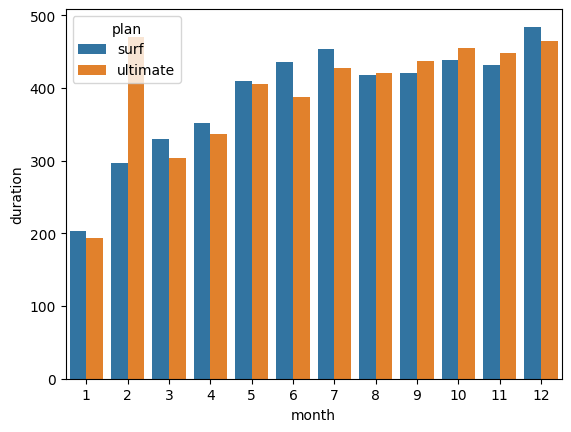

In [221]:
sns.barplot(data= duracion_promedio, x='month', y='duration', hue ='plan' ) #libreria para hacer graficas

In [222]:
# Compara el número de minutos mensuales que necesitan los usuarios de cada plan. Traza un histograma.
minutos_por_plan_mes = merge_final[['plan', 'duration']]
plan_surf = minutos_por_plan_mes.query("plan == 'surf'" ) 
plan_ultimate = minutos_por_plan_mes.query("plan == 'ultimate'")
plan_surf.head()


,plan,duration
1,surf,182.0
2,surf,315.0
3,surf,393.0
4,surf,426.0
5,surf,412.0


In [223]:
plan_ultimate.head()

,plan,duration
0,ultimate,124.0
19,ultimate,10.0
20,ultimate,59.0
26,ultimate,476.0
27,ultimate,446.0


(array([ 37.,  33.,  49.,  70.,  74.,  62., 114.,  81.,  55.,  41.,  39.,
         18.,  10.,  10.,   4.,   4.,   2.,   7.,   2.,   1.]),
 array([   0.  ,   68.45,  136.9 ,  205.35,  273.8 ,  342.25,  410.7 ,
         479.15,  547.6 ,  616.05,  684.5 ,  752.95,  821.4 ,  889.85,
         958.3 , 1026.75, 1095.2 , 1163.65, 1232.1 , 1300.55, 1369.  ]),
 <BarContainer object of 20 artists>)

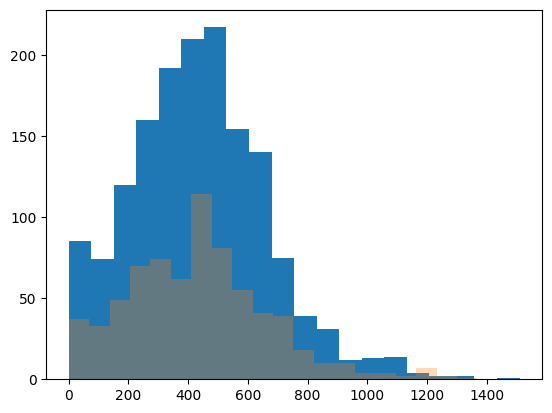

In [224]:
plt.hist(plan_surf['duration'], bins = 20)
plt.hist(plan_ultimate['duration'], bins = 20, alpha=0.3)

[Calcula la media y la variable de la duración de las llamadas para averiguar si los usuarios de los distintos planes se comportan de forma diferente al realizar sus llamadas.]

In [225]:
# Calcula la media y la varianza de la duración mensual de llamadas.
media_duracion = merge_final['duration'].mean()
media_duracion

435.9375553587245

In [226]:
varianza_duracion = merge_final['duration'].var()
varianza_duracion

53811.16800855365

<AxesSubplot:xlabel='month', ylabel='duration'>

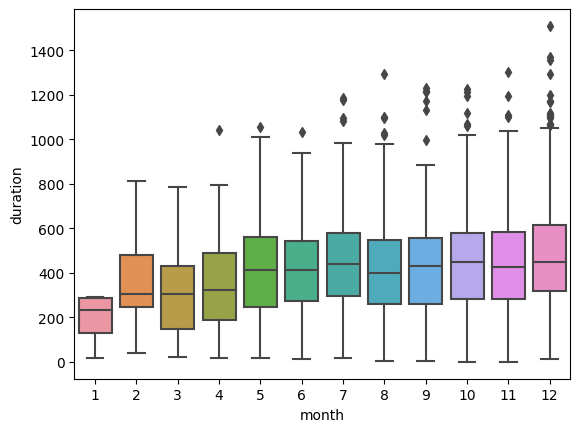

In [227]:

sns.boxplot(
    data=merge_final,
    x='month',
    y='duration')

[Elabora las conclusiones sobre el comportamiento de los usuarios con respecto a las llamadas. ¿Su comportamiento varía en función del plan?]

independientemente al plan de cada usuario, podemos observar que mensualmente el promedio de la duracion en las llamadas se mantiene casi estable a lo largo del año

### Mensajes

<AxesSubplot:xlabel='month', ylabel='num_mensajes'>

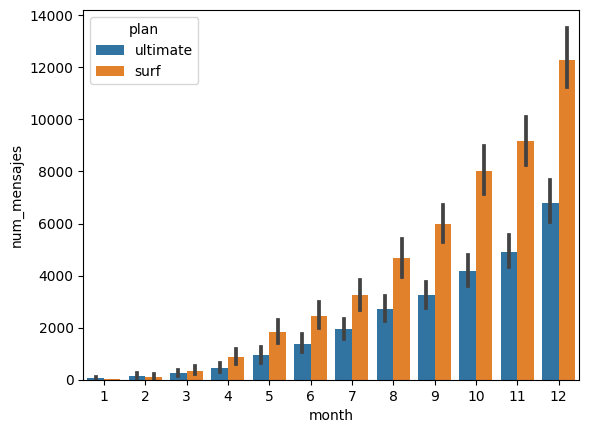

In [228]:
sns.barplot(data= merge_final, x='month', y='num_mensajes', hue ='plan', estimator = np.sum ) # Comprara el número de mensajes que tienden a enviar cada mes los usuarios de cada plan

Podemos observar que pocos usuarios generaan un pago extra por mensajes y los que lo generan son usuarios del plan surf

### Internet

In [229]:
# Compara la cantidad de tráfico de Internet consumido por usuarios por plan

<AxesSubplot:xlabel='plan', ylabel='gb_used'>

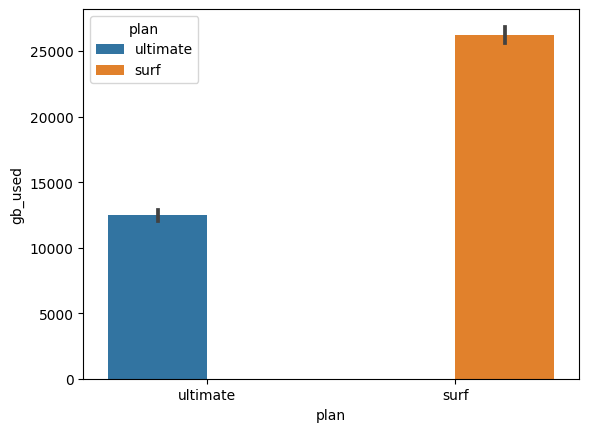

In [230]:
sns.barplot (data= merge_final, x='plan', y='gb_used', hue='plan', estimator=np.sum)

De igual manera observamos que el mayor ingreso extra que generan ambos planes es por concepto de gb extras usuados

## Ingreso

In [231]:
merge_final[['usd_monthly_pay', 'costo_extra_total', 'costo_mensajes_excedentes', 'costo_gb_excedentes', 'costo_min_excedentes']].describe()

,usd_monthly_pay,costo_extra_total,costo_mensajes_excedentes,costo_gb_excedentes,costo_min_excedentes
count,2293.000000,2293.000000,2293.000000,2293.000000,2293.000000
mean,35.699956,28.651191,0.144322,27.242041,1.264828
std,23.210863,49.623494,0.493515,48.571724,3.233992
min,20.000000,0.000000,0.000000,0.000000,0.000000
25%,20.000000,0.000000,0.000000,0.000000,0.000000
50%,20.000000,0.420000,0.000000,0.000000,0.000000
75%,70.000000,41.200000,0.000000,40.000000,0.000000
max,70.000000,570.370000,6.480000,550.000000,30.300000


## Prueba las hipótesis estadísticas

[Prueba la hipótesis de que son diferentes los ingresos promedio procedentes de los usuarios de los planes de llamada Ultimate y Surf.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [232]:
# Prueba las hipótesis
merge_final.head()


,user_id,month,num_mensajes,mb_used,gb_used,duration,plan,messages_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,hours_included,costo_mensajes_excedentes,costo_gb_excedentes,costo_min_excedentes,costo_extra_total,costo_total
0,1000,12,11.0,1901.47,2.0,124.0,ultimate,1000,70,7,0.01,0.01,30.0,50.000000,0.00,0.0,0.0,0.00,70.00
1,1001,8,30.0,6919.15,7.0,182.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.0,0.00,20.00
2,1001,9,44.0,13314.82,14.0,315.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.0,0.00,20.00
3,1001,10,53.0,22330.49,22.0,393.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.09,70.0,0.0,70.09,90.09
4,1001,11,36.0,18504.30,19.0,426.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,40.0,0.0,40.00,60.00


In [233]:
merge_final['ingreso_final'] = merge_final['usd_monthly_pay'] + merge_final['costo_extra_total']
merge_final

,user_id,month,num_mensajes,mb_used,gb_used,duration,plan,messages_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,hours_included,costo_mensajes_excedentes,costo_gb_excedentes,costo_min_excedentes,costo_extra_total,costo_total,ingreso_final
0,1000,12,11.0,1901.47,2.0,124.0,ultimate,1000,70,7,0.01,0.01,30.0,50.000000,0.00,0.0,0.0,0.00,70.00,70.00
1,1001,8,30.0,6919.15,7.0,182.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.0,0.00,20.00,20.00
2,1001,9,44.0,13314.82,14.0,315.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.0,0.00,20.00,20.00
3,1001,10,53.0,22330.49,22.0,393.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.09,70.0,0.0,70.09,90.09,90.09
4,1001,11,36.0,18504.30,19.0,426.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,40.0,0.0,40.00,60.00,60.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1498,12,NaN,23137.69,23.0,339.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,80.0,0.0,80.00,100.00,100.00
2289,1499,9,NaN,12984.76,13.0,346.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.0,0.00,20.00,20.00
2290,1499,10,NaN,19492.43,20.0,385.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,50.0,0.0,50.00,70.00,70.00
2291,1499,11,NaN,16813.83,17.0,308.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,20.0,0.0,20.00,40.00,40.00


In [234]:
ultimate = merge_final[merge_final['plan'] == 'ultimate']['ingreso_final']
ultimate

0       70.0
19      70.0
20      84.0
26      70.0
27      70.0
        ... 
2269    70.0
2270    70.0
2271    70.0
2272    70.0
2273    70.0
Name: ingreso_final, Length: 720, dtype: float64

In [235]:
surf = merge_final[merge_final['plan'] == 'surf']['ingreso_final']
surf

1        20.00
2        20.00
3        90.09
4        60.00
5        60.00
         ...  
2288    100.00
2289     20.00
2290     70.00
2291     40.00
2292     90.00
Name: ingreso_final, Length: 1573, dtype: float64

In [250]:
alpha= 0.05
varianza_levene = levene(ultimate, surf)
if varianza_levene.pvalue < alpha:
    print('Rechazamos hipotesis nula: Varianza diferente')
else: 
    print('No se puede rechazar la hipotesis: Varianza puede ser igual')


Rechazamos hipotesis nula: Varianza diferente


In [236]:
#Asumiendo que las varianzas son desigual
estadistico, pvalue = ttest_ind(ultimate, surf, equal_var=False)
print(estadistico)
print(pvalue)

7.952094891333888
3.1703905481135734e-15


In [237]:
if pvalue < 0.05 : 
    print('La hipotesis se rechaza por que los ingresos son significativamente diferentes')
else : 
    print('la hipotesis no se rechaza')

La hipotesis se rechaza por que los ingresos son significativamente diferentes


<AxesSubplot:xlabel='month', ylabel='ingreso_final'>

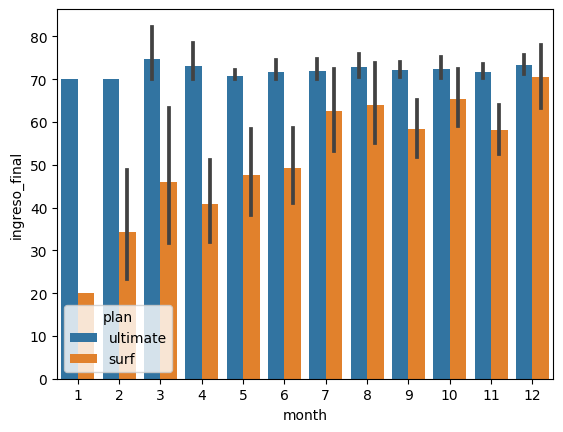

In [238]:
sns.barplot( data= merge_final, x='month', y='ingreso_final', hue='plan')

[Prueba la hipótesis de que el ingreso promedio de los usuarios del área NY-NJ es diferente al de los usuarios de otras regiones.]

[Elabora las hipótesis nula y alternativa, escoge la prueba estadística, determina el valor alfa.]

In [239]:
users.head()

,user_id,first_name,last_name,age,city,reg_date,plan,churn_date,month_reg_date
0,1000,Anamaria,Bauer,45,"Atlanta-Sandy Springs-Roswell, GA MSA",2018-12-24,ultimate,NaN,12
1,1001,Mickey,Wilkerson,28,"Seattle-Tacoma-Bellevue, WA MSA",2018-08-13,surf,NaN,8
2,1002,Carlee,Hoffman,36,"Las Vegas-Henderson-Paradise, NV MSA",2018-10-21,surf,NaN,10
3,1003,Reynaldo,Jenkins,52,"Tulsa, OK MSA",2018-01-28,surf,NaN,1
4,1004,Leonila,Thompson,40,"Seattle-Tacoma-Bellevue, WA MSA",2018-05-23,surf,NaN,5


In [240]:
merge_final.head()

,user_id,month,num_mensajes,mb_used,gb_used,duration,plan,messages_included,usd_monthly_pay,usd_per_gb,usd_per_message,usd_per_minute,gb_per_month_included,hours_included,costo_mensajes_excedentes,costo_gb_excedentes,costo_min_excedentes,costo_extra_total,costo_total,ingreso_final
0,1000,12,11.0,1901.47,2.0,124.0,ultimate,1000,70,7,0.01,0.01,30.0,50.000000,0.00,0.0,0.0,0.00,70.00,70.00
1,1001,8,30.0,6919.15,7.0,182.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.0,0.00,20.00,20.00
2,1001,9,44.0,13314.82,14.0,315.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,0.0,0.0,0.00,20.00,20.00
3,1001,10,53.0,22330.49,22.0,393.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.09,70.0,0.0,70.09,90.09,90.09
4,1001,11,36.0,18504.30,19.0,426.0,surf,50,20,10,0.03,0.03,15.0,8.333333,0.00,40.0,0.0,40.00,60.00,60.00


In [241]:
merge_final =merge_final.merge(users[['user_id', 'city']], on='user_id', how='left')
merge_final.head()

,user_id,month,num_mensajes,mb_used,gb_used,duration,plan,messages_included,usd_monthly_pay,usd_per_gb,...,usd_per_minute,gb_per_month_included,hours_included,costo_mensajes_excedentes,costo_gb_excedentes,costo_min_excedentes,costo_extra_total,costo_total,ingreso_final,city
0,1000,12,11.0,1901.47,2.0,124.0,ultimate,1000,70,7,...,0.01,30.0,50.000000,0.00,0.0,0.0,0.00,70.00,70.00,"Atlanta-Sandy Springs-Roswell, GA MSA"
1,1001,8,30.0,6919.15,7.0,182.0,surf,50,20,10,...,0.03,15.0,8.333333,0.00,0.0,0.0,0.00,20.00,20.00,"Seattle-Tacoma-Bellevue, WA MSA"
2,1001,9,44.0,13314.82,14.0,315.0,surf,50,20,10,...,0.03,15.0,8.333333,0.00,0.0,0.0,0.00,20.00,20.00,"Seattle-Tacoma-Bellevue, WA MSA"
3,1001,10,53.0,22330.49,22.0,393.0,surf,50,20,10,...,0.03,15.0,8.333333,0.09,70.0,0.0,70.09,90.09,90.09,"Seattle-Tacoma-Bellevue, WA MSA"
4,1001,11,36.0,18504.30,19.0,426.0,surf,50,20,10,...,0.03,15.0,8.333333,0.00,40.0,0.0,40.00,60.00,60.00,"Seattle-Tacoma-Bellevue, WA MSA"


In [242]:
merge_final['NY-NJ']=merge_final['city'].str.contains('NY-NJ')
merge_final


,user_id,month,num_mensajes,mb_used,gb_used,duration,plan,messages_included,usd_monthly_pay,usd_per_gb,...,gb_per_month_included,hours_included,costo_mensajes_excedentes,costo_gb_excedentes,costo_min_excedentes,costo_extra_total,costo_total,ingreso_final,city,NY-NJ
0,1000,12,11.0,1901.47,2.0,124.0,ultimate,1000,70,7,...,30.0,50.000000,0.00,0.0,0.0,0.00,70.00,70.00,"Atlanta-Sandy Springs-Roswell, GA MSA",False
1,1001,8,30.0,6919.15,7.0,182.0,surf,50,20,10,...,15.0,8.333333,0.00,0.0,0.0,0.00,20.00,20.00,"Seattle-Tacoma-Bellevue, WA MSA",False
2,1001,9,44.0,13314.82,14.0,315.0,surf,50,20,10,...,15.0,8.333333,0.00,0.0,0.0,0.00,20.00,20.00,"Seattle-Tacoma-Bellevue, WA MSA",False
3,1001,10,53.0,22330.49,22.0,393.0,surf,50,20,10,...,15.0,8.333333,0.09,70.0,0.0,70.09,90.09,90.09,"Seattle-Tacoma-Bellevue, WA MSA",False
4,1001,11,36.0,18504.30,19.0,426.0,surf,50,20,10,...,15.0,8.333333,0.00,40.0,0.0,40.00,60.00,60.00,"Seattle-Tacoma-Bellevue, WA MSA",False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2288,1498,12,NaN,23137.69,23.0,339.0,surf,50,20,10,...,15.0,8.333333,0.00,80.0,0.0,80.00,100.00,100.00,"New York-Newark-Jersey City, NY-NJ-PA MSA",True
2289,1499,9,NaN,12984.76,13.0,346.0,surf,50,20,10,...,15.0,8.333333,0.00,0.0,0.0,0.00,20.00,20.00,"Orlando-Kissimmee-Sanford, FL MSA",False
2290,1499,10,NaN,19492.43,20.0,385.0,surf,50,20,10,...,15.0,8.333333,0.00,50.0,0.0,50.00,70.00,70.00,"Orlando-Kissimmee-Sanford, FL MSA",False
2291,1499,11,NaN,16813.83,17.0,308.0,surf,50,20,10,...,15.0,8.333333,0.00,20.0,0.0,20.00,40.00,40.00,"Orlando-Kissimmee-Sanford, FL MSA",False


In [243]:
NY_NJ= merge_final[merge_final['NY-NJ']]['ingreso_final']
NY_NJ

37       20.00
38       38.84
59       20.00
60       70.00
61       40.00
         ...  
2284     70.00
2285    100.00
2286     80.00
2287     60.00
2288    100.00
Name: ingreso_final, Length: 377, dtype: float64

In [244]:
otras_ciudades = merge_final[~merge_final['NY-NJ']]['ingreso_final']
otras_ciudades

0       70.00
1       20.00
2       20.00
3       90.09
4       60.00
        ...  
2273    70.00
2289    20.00
2290    70.00
2291    40.00
2292    90.00
Name: ingreso_final, Length: 1916, dtype: float64

In [249]:
alpha= 0.05
varianza_levene = levene(NY_NJ, otras_ciudades)
if varianza_levene.pvalue < alpha:
    print('Rechazamos hipotesis nula: Varianza diferente')
else: 
    print('No se puede rechazar la hipotesis: Varianza puede ser igual')


No se puede rechazar la hipotesis: Varianza puede ser igual


In [251]:
# Prueba las hipótesis 
estadistico, pvalue = ttest_ind(NY_NJ, otras_ciudades)
print(estadistico)
print(pvalue)


-2.0194429818968103
0.043557431621342436


In [252]:
if pvalue < 0.05 : 
    print('La hipotesis se rechaza por que los ingresos son significativamente diferentes')
else : 
    print('la hipotesis no se rechaza')

La hipotesis se rechaza por que los ingresos son significativamente diferentes


<AxesSubplot:xlabel='month', ylabel='ingreso_final'>

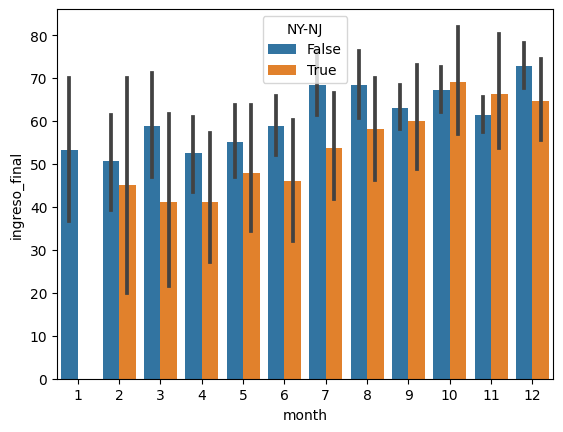

In [253]:
sns.barplot( data= merge_final, x='month', y='ingreso_final', hue='NY-NJ')

## Conclusión general



1.- la mayor cantidad de los usuarios del plan surf tienden a pagar mas por el concepto de gb_usados, generando un mayor ingreso que el plan ultimate al incluir menos gb, siendo estos el concepto mas caro por plan

2.-Aun que los ingresos son diferentes, no observamos un cambio considerable en el gasto extra de las personas dependiendo de la zona o ciudad donde viven.

3.- El paquete surf es el que maneja mejores ingresos ya que ofrece solo 15gb por mes cuando la mayoria de los clientes se exceden en su consumo